In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

import jsm_routines
import galhalo
import os

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


### unevolved

In [ ]:
datadir = "../../prelim/output_tree/"

In [ ]:
Nreal = len([entry for entry in os.listdir(datadir)])
Nhalo = 200

acc_mass = np.zeros(shape=(Nreal, Nhalo))

acc_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
for i,filename in enumerate(os.listdir(datadir)):
        
    file = os.path.join(datadir, filename)
        
    mass_clean, red_clean = accretion_mass(file)
    
    mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)
    
    red = np.pad(red_clean, (0,Nhalo-len(red_clean)), mode="constant", constant_values=np.nan)
    
    acc_mass[i,:] = mass
    
    acc_redshift[i,:] = red

In [ ]:
SHMF(acc_mass, acc_redshift)

### surviving

In [ ]:
datadir = "../../prelim/output_evolve/"

In [ ]:
Nreal = len([entry for entry in os.listdir(datadir)])
Nhalo = 200

surv_mass = np.zeros(shape=(Nreal, Nhalo))

surv_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
for i,filename in enumerate(os.listdir(datadir)):
        
    file = os.path.join(datadir, filename)
        
    mass_clean = surviving_mass(file, 10**9)
    
    mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)
        
    surv_mass[i,:] = mass

In [ ]:
SHMF(surv_mass, 0)

### accreation mass of surviving

In [ ]:
Nreal = len([entry for entry in os.listdir(datadir)])
Nhalo = 200

surv_acc_mass = np.zeros(shape=(Nreal, Nhalo))

surv_acc_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
for i,filename in enumerate(os.listdir(datadir)):
        
    file = os.path.join(datadir, filename)
        
    mass_clean, red_clean = accretion_mass_surv(file, 10**9)
    
    mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)
    
    red = np.pad(red_clean, (0,Nhalo-len(red_clean)), mode="constant", constant_values=np.nan)
    
    surv_acc_mass[i,:] = mass
    
    surv_acc_redshift[i,:] = red

### trying to recreate the SatGen plot

In [ ]:
data = np.load("../../data/12_4_0/numpy/surv_mass.npy")

In [ ]:
mass_frac = data
mass_frac[:, 0] = 0.0  # removing the host mass from the matrix
zero_mask = mass_frac != 0.0 
ana_mass = np.log10(np.where(zero_mask, mass_frac, np.nan))  # up until here the stats are good

In [ ]:
for i in range(200):
    test = ana_mass[i]

    counts, bins = np.histogram(test, bins=15, range=(-4, -0.1))

    binsize = (bins[1] - bins[0])
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    plt.plot(bincenters, np.log10(counts))
plt.xlabel("halo mass m/M")
plt.show()

In [ ]:
# for a single host! (or realization)

for i in range(200):
    test = data[i]
    test[0] = 0.0
    new = np.log10(test[test != 0.0])
    
    counts, bins = np.histogram(new, bins=15, range=(8,12))

    binsize = (bins[1] - bins[0])
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    plt.plot(bincenters, np.log10(counts))
plt.xlabel("halo mass")
plt.show()

### working out CMF with redshift evo

In [ ]:
data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")

red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

In [ ]:

data[:, 0] = 0.0  # removing the host mass from the matrix
zero_mask = data != 0.0 #masking the padding!
Mh = np.log10(np.where(zero_mask, data, np.nan)) #switching the to nans!


In [ ]:
red[:, 0] = np.nan # removing the host mass from the matrix

In [ ]:
Ms = galhalo.lgMs_RP17(Mh, z=red)

In [ ]:
mass_range = np.linspace(np.nanmin(Ms), np.nanmax(Ms), 100)

I = np.zeros((Ms.shape[0], 100))

for i,realization in enumerate(Ms): #this double for loop can probably be replaced!
    for j,mass in enumerate(mass_range):
        I[i,j] = np.sum(realization > mass)
        
CSMF_quant = np.percentile(I, [5, 50, 95], axis=0) # the percentiles
        
plt.figure(figsize=(8, 8))

plt.plot(mass_range, CSMF_quant[1, :], label="median", color="black")
plt.fill_between(mass_range, y1=CSMF_quant[0, :], y2=CSMF_quant[2, :], alpha=0.2, color="grey")
plt.grid(alpha=0.4)
plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()

In [ ]:
mass, quant = jsm_routines.CSMF(data)

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(mass_range, CSMF_quant[1, :], label="Behroozi SHMR (based on accreation z)", color="black")
plt.fill_between(mass_range, y1=CSMF_quant[0, :], y2=CSMF_quant[2, :], alpha=0.2, color="grey")

plt.plot(mass, quant[1, :], label="Danieli SHMR (no z dependance)", color="green")
plt.fill_between(mass, y1=quant[0, :], y2=quant[2, :], alpha=0.2, color="green")

plt.grid(alpha=0.4)
plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(galhalo.lgMs_D22_det(10**xs), np.log10(ys), label="sorting + \nthe median mass range")
plt.plot(mass, np.log10(quant[1]), label="no sorting + \nusing an evenly spaced mass range")
plt.fill_between(mass, y1=np.log10(quant[0]), y2=np.log10(quant[2]), alpha=0.2, color="grey")
plt.grid(alpha=0.4)
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()

In [ ]:
###Now looking at the redshift evolution

In [ ]:
def test_relation(lgMv, log_e, a):

    """
    returns the determinisitic stellar mass [M_sun]
    """
    
    #log_e = -1.5
    #a = 1.82
    lgMs = log_e + 12.5 + a*lgMv - a*12.5

    return lgMs


In [ ]:
def new_relation(Mv, e, a):

    """
    non log form of the equation
    """
    
    #log_e = -1.5 , e = 0.031
    #a = 1.82
    M1=(10**12.5)
    intercept = e*(M1**(1-a))
    slope = (Mv**a)
    return intercept * slope


In [ ]:
data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")

data[:, 0] = 0.0  # removing the host mass from the matrix
zero_mask = data != 0.0 #masking the padding!
Mh = np.log10(np.where(zero_mask, data, np.nan)) #switching the to nans!

halo_mass = Mh[0]


In [ ]:
stellar_mass = new_relation(10**halo_mass, 0.031, 1.82)
intercept_vals = [0.01, 0.02, 0.06, 0.09]

plt.title("changing the intercept")
plt.plot(halo_mass, stellar_mass, label="0.031", color="black")
for i in intercept_vals:
    plt.plot(halo_mass, new_relation(10**halo_mass, i, 1.82), ls="--", label=str(i))
plt.legend()
plt.yscale("log")
plt.show()

In [ ]:
stellar_mass = new_relation(10**halo_mass, 0.031, 1.82)
slope_vals = [1, 1.5, 2, 2.5]

plt.title("changing the slope")
plt.plot(halo_mass, stellar_mass, label="0.031", color="black")
for i in slope_vals:
    plt.plot(halo_mass, new_relation(10**halo_mass, 0.031, i), ls="--", label=str(i))
plt.legend()
plt.yscale("log")
plt.show()

### trying to make the CSMF faster

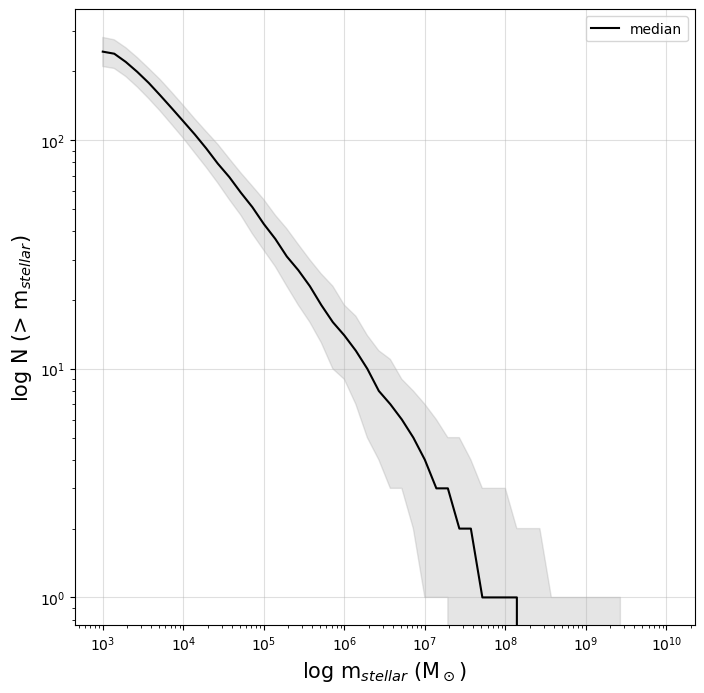

In [3]:
as_data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")
as_red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

Ms = jsm_routines.SHMR(as_data)

surv_massr, surv_CSMF = jsm_routines.CSMF(Ms) # accreation mass of the surviving halos!

In [ ]:
Ms

In [ ]:
max_real = Ms.shape[1] - np.sum(np.isnan(Ms),axis=1)

npix = 50

mass_range = np.logspace(3,10,npix)


In [ ]:
I = np.zeros((Ms.shape[0], npix))

for i,realization in enumerate(Ms): #this double for loop can probably be replaced!
    for j,mass in enumerate(mass_range):
        I[i,j] = np.sum(realization[1:max_real[i]] > np.log10(mass))

In [ ]:
I_new = np.zeros((Ms.shape[0], npix))


for i,realization in enumerate(Ms): #this double for loop can probably be replaced!
    for j,mass in enumerate(mass_range):
        I_new[i,j] = np.sum(realization > np.log10(mass))

In [ ]:
test = np.sum(Ms > np.log10(mass_range[0]),axis=1)

In [ ]:
I_best = np.zeros((npix, Ms.shape[0]))

for i,val in enumerate(mass_range):

    I_best[i] = np.sum(Ms > np.log10(val),axis=1)

In [ ]:
CSMF_quant = np.percentile(I_best.transpose(), [5, 50, 95], axis=0) # the percentiles

In [ ]:
CSMF_quant[2] - CSMF_quant[0]

### testing the SMF

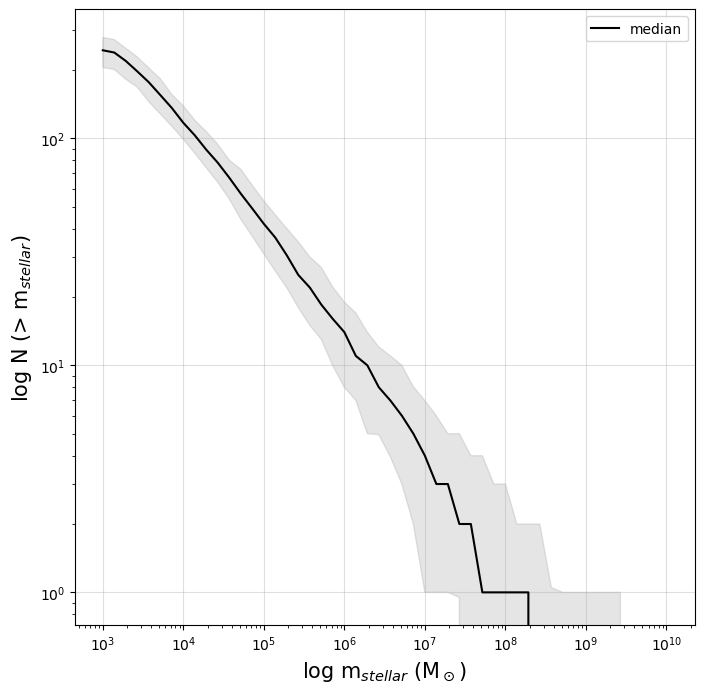

In [3]:
as_data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")
as_red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

mass, CSMF = jsm_routines.CSMF(jsm_routines.SHMR(as_data[0:100]))

In [4]:
def CSMF_1D(Ms, Npix=50, plot=True):

    """
    calculates the cumulative satellite mass function given a number of mass ind
    input mass should not be in log space
    """
    # the same x-array for all the CSMFs
    mass_range = np.logspace(3,10,Npix)
    I = [np.sum(Ms > np.log10(i)) for i in mass_range]
                    
    if plot==True:
        
        plt.figure(figsize=(8, 8))

        plt.plot(mass_range, I, color="black")
        plt.grid(alpha=0.4)
        plt.yscale("log")
        plt.xscale("log")
        plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
        plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
        plt.legend()
        plt.show()

    return I

In [5]:
test = []
 
for i in range(100):

    Mh = as_data[i]
    Mh[0] = 0.0  # removing the host mass from the matrix
    zero_mask = Mh != 0.0 
    Mh = np.log10(np.where(zero_mask, Mh, np.nan)) #switching the to nans!

    test.append(CSMF_1D(galhalo.lgMs_D22_det(Mh), plot=False))

mass_range = np.logspace(3,10,50)


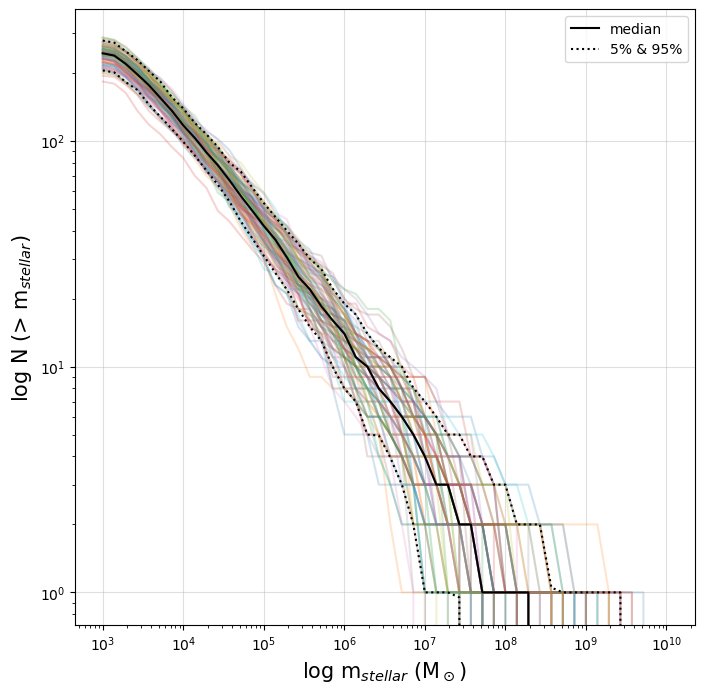

In [6]:

plt.figure(figsize=(8, 8))

for i in test:
    plt.plot(mass_range, i, alpha=0.2)

plt.plot(mass, CSMF[1], color="black", label="median")
plt.plot(mass, CSMF[0], color="black", label="5% & 95%", ls=":")
plt.plot(mass, CSMF[2], color="black", ls=":")

plt.grid(alpha=0.4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()

plt.savefig("../figures/CSMF_Nreal.pdf")
plt.show()


### now looking at the difference between the lognormal distribution and the normal

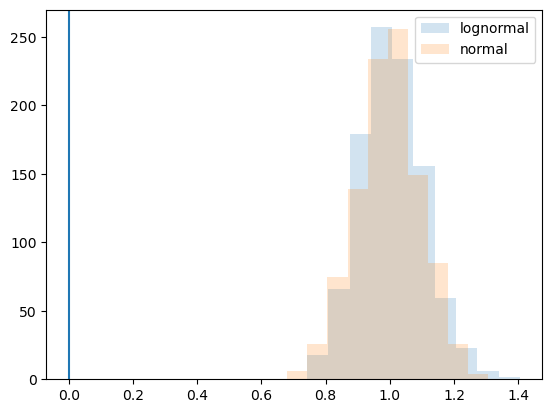

In [58]:
dex = 0.1

plt.hist(np.random.lognormal(sigma=dex, size=1000), alpha=0.2, label="lognormal")
plt.hist(np.random.normal(loc=1, scale=dex, size=1000), alpha=0.2, label="normal")
plt.axvline()
plt.legend()
plt.show()

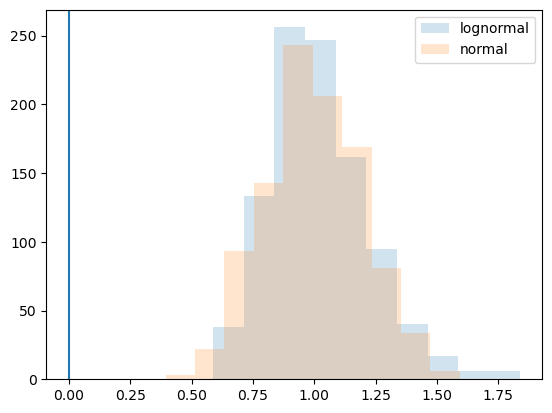

In [59]:
dex = 0.2

plt.hist(np.random.lognormal(sigma=dex, size=1000), alpha=0.2, label="lognormal")
plt.hist(np.random.normal(loc=1, scale=dex, size=1000), alpha=0.2, label="normal")
plt.axvline()
plt.legend()
plt.show()

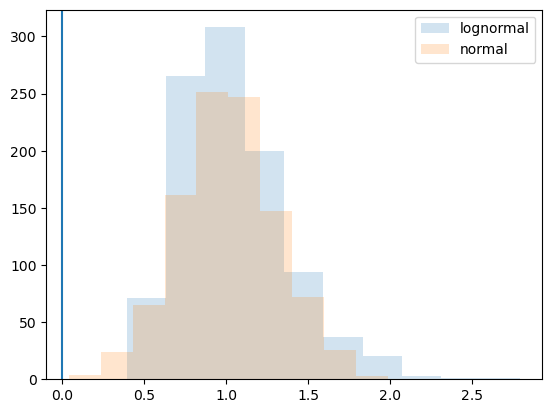

In [60]:
dex = 0.3

plt.hist(np.random.lognormal(sigma=dex, size=1000), alpha=0.2, label="lognormal")
plt.hist(np.random.normal(loc=1, scale=dex, size=1000), alpha=0.2, label="normal")
plt.axvline()
plt.legend()
plt.show()

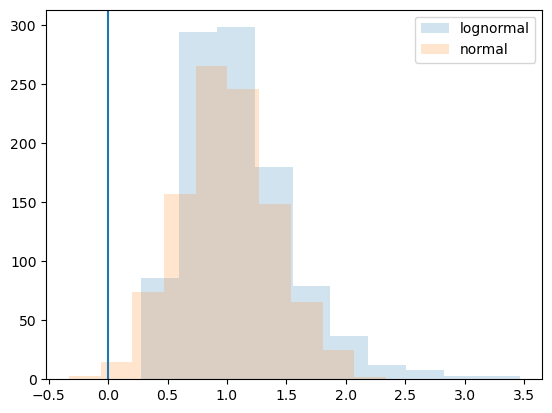

In [61]:
dex = 0.4

plt.hist(np.random.lognormal(sigma=dex, size=1000), alpha=0.2, label="lognormal")
plt.hist(np.random.normal(loc=1, scale=dex, size=1000), alpha=0.2, label="normal")
plt.axvline()
plt.legend()
plt.show()

this shows that the lognormal distribution never passes below zero and is more appropriate than the normal if you want to take the log of it afterwards

(array([741., 175.,  48.,  16.,   7.,   6.,   3.,   2.,   1.,   1.]),
 array([ 0.02562972,  2.08130972,  4.13698972,  6.19266972,  8.24834972,
        10.30402972, 12.35970971, 14.41538971, 16.47106971, 18.52674971,
        20.58242971]),
 <BarContainer object of 10 artists>)

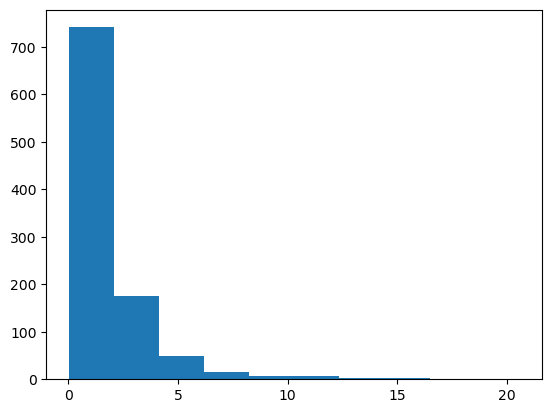

In [4]:
plt.hist(np.random.lognormal(size=1000))

(array([  4.,   6.,   9.,  26.,  39.,  74., 112., 194., 331., 492., 640.,
        796., 942., 986., 999., 982., 881., 737., 624., 478., 269., 189.,
         89.,  51.,  26.,  10.,  12.,   1.,   0.,   1.]),
 array([-3.79845043, -3.53386432, -3.26927821, -3.0046921 , -2.74010599,
        -2.47551988, -2.21093377, -1.94634766, -1.68176155, -1.41717544,
        -1.15258933, -0.88800322, -0.62341711, -0.358831  , -0.09424489,
         0.17034122,  0.43492733,  0.69951344,  0.96409955,  1.22868566,
         1.49327177,  1.75785788,  2.02244399,  2.2870301 ,  2.55161621,
         2.81620232,  3.08078843,  3.34537454,  3.60996065,  3.87454676,
         4.13913287]),
 <BarContainer object of 30 artists>)

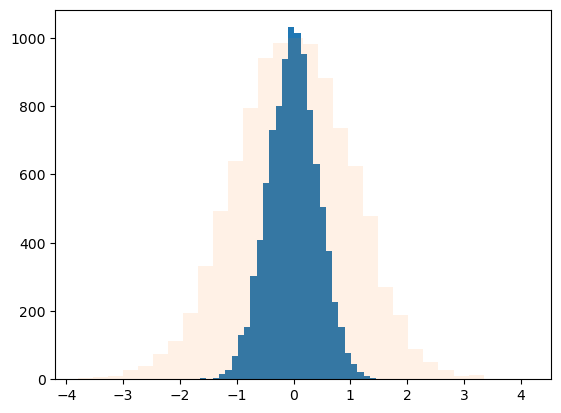

In [13]:
plt.hist(np.log10(np.random.lognormal(size=10000)), bins=30)
plt.hist(np.random.normal(size=10000), bins=30, alpha=0.1)

In [52]:
halo_masses = np.logspace(5,8,10)

halo_mass = np.log10(halo_masses[5])

In [57]:
halo_mass

sampling = np.random.normal(loc=6, scale=0.5, size=1000)

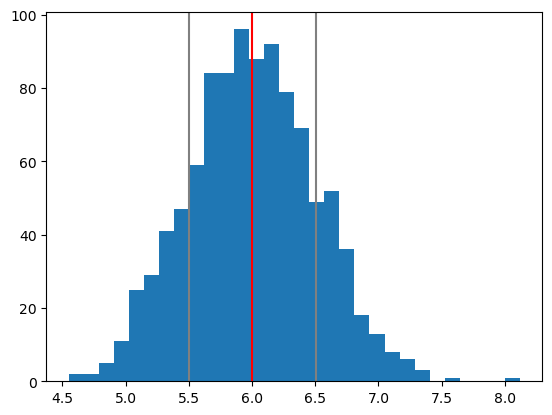

In [58]:
plt.hist(sampling, bins=30)
plt.axvline(np.mean(sampling), color="red")
plt.axvline(np.mean(sampling)-np.std(sampling), color="grey")
plt.axvline(np.mean(sampling)+np.std(sampling), color="grey")
plt.show()
